In [101]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import finnhub
import GetOldTweets3 as got
import requests
import pytrends
from pytrends.request import TrendReq
from ta import add_all_ta_features
import praw
import pandas as pd
import os
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import keras
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
import numpy as np
import plotly.express as px
import alpha_vantage

In [102]:
ticker = 'ADM'

Get Google Trend

In [106]:
from pytrends_fetcher import PyTrendsFetcher

if not os.path.exists('input/' + ticker + '_daily.csv'):
    fetcher = PyTrendsFetcher(max_retries=5, wait_time=60)
    try:
        data = fetcher.fetch_data_with_retry(ticker, start_year=2024, start_mon=1, stop_year=2024, stop_mon=3, geo='')
        print("Data fetched successfully.")
        
        # Select the relevant columns
        data = data[[ticker + '_unscaled']]
        
        # Save the data to a CSV file
        data.to_csv('input/' + ticker + '_daily.csv', header=True)
    except Exception as e:
        print(str(e))
else:
    # Load the data from the existing file
    data = pd.read_csv('input/' + ticker + '_daily.csv', index_col=0)
    print("Data loaded from existing file.")

module 'pytrends.dailydata' has no attribute 'TooManyRequestsError'


In [104]:
ticker_daily = data
fig = px.line(ticker_daily, y=[ticker + '_unscaled'], title='Keyword Web Search Interest Over Time')
fig.show()

ValueError: All arguments should have the same length. The length of argument `y` is 1, whereas the length of  previously-processed arguments ['date'] is 91

Retrieve News

In [ ]:
import sqlite3
import pandas as pd

def export_table_to_csv(database_path, table_name, csv_file_path):
    # Connect to the SQLite database
    conn = sqlite3.connect(database_path)
    
    # Query to select all data from the table
    query = f"SELECT * FROM {table_name}"
    
    # Use pandas to read the SQL query into a DataFrame
    df = pd.read_sql_query(query, conn)
    
    # Export the DataFrame to a CSV file
    df.to_csv(csv_file_path, index=False)
    
    # Close the database connection
    conn.close()

# Usage example
database_path = 'input/financial_data.db'
table_name = ticker + '_'  # Replace with your table name
csv_file_path = 'input/' + ticker + '_data.csv'  # Path where you want to save the CSV file

export_table_to_csv(database_path, table_name, csv_file_path)


Perform Sentiment Analysis

In [ ]:
df = pd.read_csv('input/' + ticker + '_data.csv')
vader = SentimentIntensityAnalyzer()

f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df.iloc[:,2].apply(f)

df['date'] = pd.to_datetime(df['datetime'], unit='s').dt.strftime('%Y-%m-%d')
df = df.drop(columns=['datetime'])
df_filtered = df[['related', 'date', 'compound']]
df_grouped = df_filtered.groupby('date', as_index=False).agg({'related': 'first', 'compound': 'mean'})

<Figure size 1000x800 with 0 Axes>

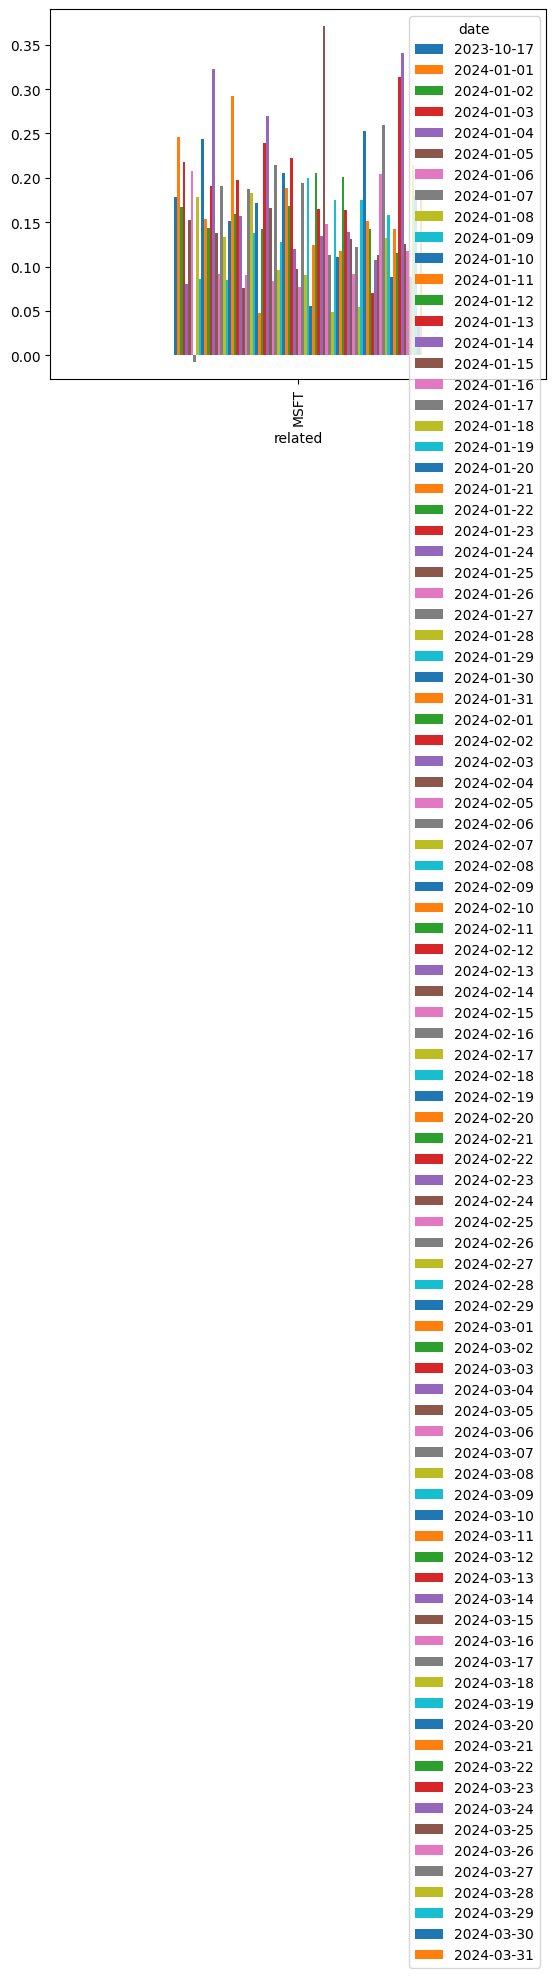

In [ ]:
plt.figure(figsize=(10,8))
mean_df = df.groupby(['related', 'date']).mean(numeric_only=True).unstack()
mean_df = mean_df.xs('compound', axis="columns")
mean_df.plot(kind='bar')
plt.show()

Get Stock Financial Data

In [ ]:
# Get stock financial data
hist = yf.Ticker(ticker).history(start='2024-01-01',end='2024-03-31')[['Close', 'Volume']]
hist.index = hist.index.tz_localize(None)
sentiment_transposed = mean_df.T
sentiment_transposed.index = pd.to_datetime(sentiment_transposed.index)

Merge DataFrames

In [ ]:
# Aligning date formats and ensuring indexes are consistent
hist.index = pd.to_datetime(hist.index)
sentiment_transposed.index = pd.to_datetime(sentiment_transposed.index)
ticker_daily.index = pd.to_datetime(ticker_daily.index)

# Merge DataFrames
merged_df = pd.merge(hist, sentiment_transposed[[ticker]], left_index=True, right_index=True, how='left')
merged_df = pd.merge(merged_df, ticker_daily[[ticker + '_unscaled']], left_index=True, right_index=True, how='left')
merged_df = merged_df.rename(columns={'Close': 'Price'})
merged_df = merged_df.rename(columns={ticker: 'Sentiment'})
merged_df = merged_df.rename(columns={ticker + '_unscaled': 'Trend'})
merged_df['Sentiment'] = merged_df['Sentiment'].fillna(0)
merged_df['Trend'] = merged_df['Trend'].fillna(0)
display(merged_df)

,Price,Volume,Sentiment,Trend
Date,,,,
2024-01-02,369.518921,25258600,0.166798,25
2024-01-03,369.249908,23083500,0.217518,24
2024-01-04,366.599579,20901500,0.080728,24
2024-01-05,366.410278,20987000,0.152707,24
2024-01-08,373.325012,23134000,0.178016,24
...,...,...,...,...
2024-03-22,427.968048,17636500,0.115066,87
2024-03-25,422.098633,18060500,0.125700,85
2024-03-26,420.890808,16725600,0.117242,75


              Price    Volume  Sentiment     Trend
Price      1.000000 -0.123347  -0.141395  0.767440
Volume    -0.123347  1.000000  -0.037337  0.137967
Sentiment -0.141395 -0.037337   1.000000 -0.182299
Trend      0.767440  0.137967  -0.182299  1.000000


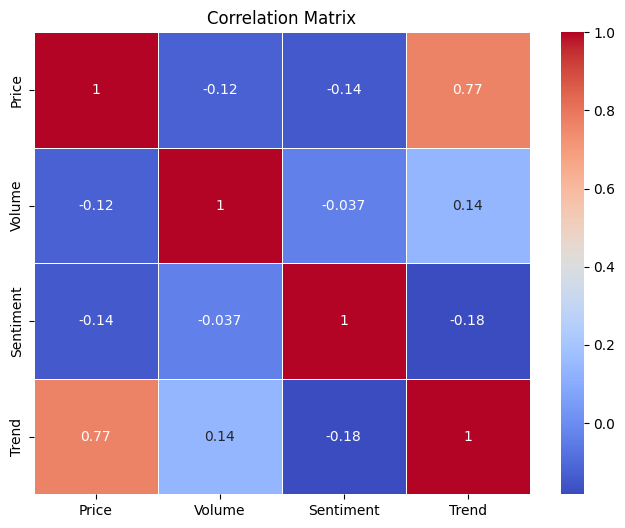

<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculate the correlation matrix
correlation_matrix = merged_df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Save the correlation matrix plot to the output folder
corr_matrix_path = os.path.join('output/correlation_matrix.png')
plt.savefig(corr_matrix_path)
plt.show()


Pre-Process Data

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_df)

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Predicting the 'Close' price
    return np.array(X), np.array(y)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences
seq_length = 10  # You can adjust this as needed
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


Create the Model

In [ ]:
# Define the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\razva\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Train the Model

In [ ]:
# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint('checkpoint/stock_price_model.keras', monitor='loss', verbose=1, save_best_only=True, mode='min')

# Train the model with ModelCheckpoint callback
model.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=[checkpoint])

# Load the model with the lowest loss
model.load_weights('checkpoint/stock_price_model.keras')


Epoch 1/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.4349
Epoch 1: loss improved from inf to 0.37043, saving model to checkpoint/stock_price_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.3919
Epoch 2/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3210
Epoch 2: loss improved from 0.37043 to 0.30595, saving model to checkpoint/stock_price_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3110
Epoch 3/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2300
Epoch 3: loss improved from 0.30595 to 0.21414, saving model to checkpoint/stock_price_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2194
Epoch 4/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1285
Epoch 4: loss improved from 0.21414 to 0.09339, saving model to checkpoint/stock_price_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1051
Epoch 5/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0331
Epoch 5: loss improved from 0.09339 to 0.01865, saving model to checkpoint/sto

Make Predictions

In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Create a placeholder array for the full feature set
# We need to have the same number of columns as the original data
full_scaler_predictions = np.zeros((predictions.shape[0], scaled_data.shape[1]))

# Place the predicted 'Close' values into the placeholder array
full_scaler_predictions[:, 0] = predictions[:, 0]

# Apply inverse transformation to the full array
inverse_predictions = scaler.inverse_transform(full_scaler_predictions)

# Extract only the 'Close' values from the inverse transformed data
final_predictions = inverse_predictions[:, 0]

# Extract true 'Close' values from test data
true_close = scaler.inverse_transform(test_data)[:, 0][seq_length:]

# Combine true close values from the entire dataset
all_close_values = scaler.inverse_transform(scaled_data)[:, 0]

# Latest known price from the training data
latest_known_price = all_close_values[len(train_data) - 1]

# Compare predictions with the latest known price
for i, predicted_price in enumerate(final_predictions):
    trend = "Bullish" if predicted_price > latest_known_price else "Bearish"
    print(f"Day {i + 1}: Predicted Close = {predicted_price:.2f}, Trend = {trend}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
Day 1: Predicted Close = 406.71, Trend = Bullish
Day 2: Predicted Close = 407.08, Trend = Bullish
Day 3: Predicted Close = 408.39, Trend = Bullish


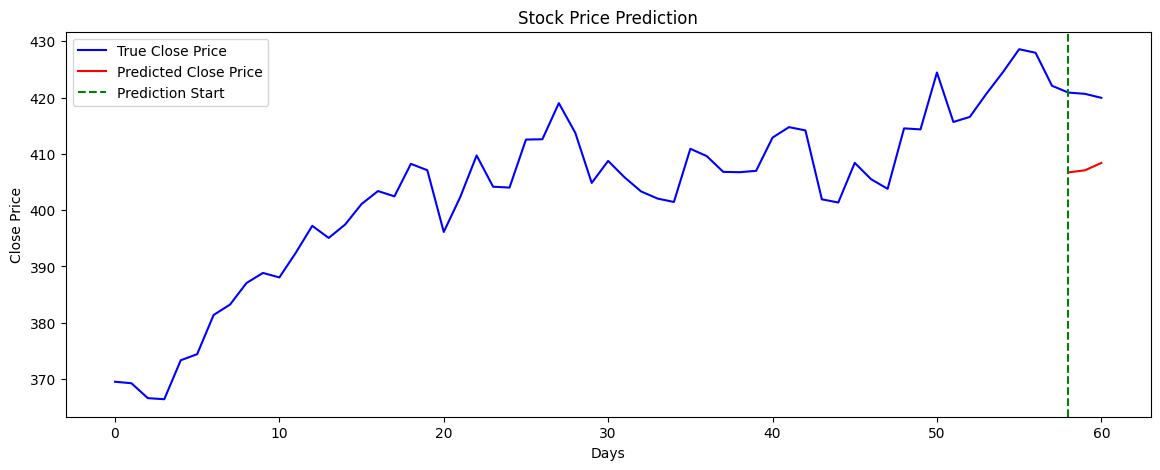

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(all_close_values, color='blue', label='True Close Price')
plt.plot(range(len(train_data) + seq_length, len(train_data) + seq_length + len(final_predictions)), final_predictions, color='red', label='Predicted Close Price')
plt.axvline(x=len(train_data) + seq_length, color='green', linestyle='--', label='Prediction Start')
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Save the plot to the output folder
plot_path = os.path.join('output/stock_price_prediction.png')
plt.savefig(plot_path)
plt.show()

In [ ]:
# Calculate the Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((true_close - final_predictions) / true_close)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 3.12%
